In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

In [3]:
# read all confirmed planets from the exoplanet archive
planets = Table.read('../data/planets2.txt', format='csv', comment='#')

In [6]:
#planets['sy_jmag']

In [7]:
# habitable zone as a function of teff from https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf

# valid from teff=2600 to 7200 K, T = T* - 5780

# moist greenhouse
coeffs_rv = 1.7763, 1.4335e-4, 3.3954e-9, -7.6364e-12, -1.1950e-15
coeffs_moistgh = 1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16
coeffs_maxgh = 0.3507, 5.9578e-5, 1.6707e-99, -3.0058e-12, -5.1925e-16
coeffs_em = 0.3207, 5.4471e-5, 1.5275e-9, -2.1709e-12, -3.8282e16

# inner and outer habitable zone insolations 
coeffs_inner = coeffs_rv
coeffs_outer = coeffs_em
hz_inner = lambda T: (coeffs_inner[0] 
                      + coeffs_inner[1]*T 
                      + coeffs_inner[2]*(T**2) 
                      + coeffs_inner[3]*(T**3) 
                      + coeffs_inner[4]*(T**4))
hz_outer = lambda T: (coeffs_outer[0] 
                      + coeffs_outer[1]*T 
                      + coeffs_outer[2]*(T**2) 
                      + coeffs_outer[3]*(T**3) 
                      + coeffs_outer[4]*(T**4))

In [8]:
teff_sol = 5777 
lum = (planets['st_rad'] ** 2) * (planets['st_teff']/teff_sol) ** 4
seff = (lum / planets['pl_orbsmax']**2)

# include planets up to 100 K hotter than optimistic HZ 
in_hz = (seff < hz_inner(planets['st_teff']-1780))
in_hz = in_hz & ~seff.mask

In [9]:
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

In [10]:
minmass_med = np.zeros(len(planets[in_hz]))
minmass_minus = np.zeros(len(planets[in_hz]))
minmass_plus = np.zeros(len(planets[in_hz]))
for i, p in enumerate(planets[in_hz]):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        minmass_med[i] = -1
        minmass_minus[i] = -1
        minmass_plus[i] = -1
    else:
        if p['pl_radj'] is np.ma.masked:
            res = mr.Rstat2M(mean=p['pl_rade'] / 11.2089, std=p['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)
        else:
            res = mr.Rstat2M(mean=p['pl_radj'], std=p['pl_radjerr1'], unit='Jupiter', sample_size=100, grid_size=100)
        if res is not None:
            m, mminus, mplus = res
            minmass_med[i] = m
            minmass_minus[i] = mminus
            minmass_plus[i] = mplus
        else:
            minmass_med[i] = -1
            minmass_minus[i] = -1
            minmass_plus[i] = -1

../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in true_divide
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.


../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.


In [11]:
from astropy.table import unique
hz_planets = planets[in_hz]
hz_planets.add_column(np.ma.masked_where(minmass_med == -1, minmass_med), name='pl_minmass_med')
hz_planets.add_column(np.ma.masked_where(minmass_plus == -1, minmass_plus), name='pl_minmass_plus')
hz_planets.add_column(np.ma.masked_where(minmass_minus == -1, minmass_minus), name='pl_minmass_minus')
hz_planets = unique(hz_planets, keys=['pl_name'], keep='last')

In [12]:
mj_ms = 0.0009543
au_rs = 1/215.032
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P, rs: (hill(mp, ms, a, e) + rs * au_rs) * P / (2 * np.pi * a)

In [13]:
th = np.zeros(len(hz_planets))
rh = np.zeros(len(hz_planets))
for i, p in enumerate(hz_planets):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], 0.0, p['pl_orbeccen'])# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
    else:
        th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0)# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
hz_planets.add_column(th, name='pl_hilltime')
hz_planets.add_column(rh, name='pl_hillrad')

<ipython-input-13-63f2808c446a>:9: UserWarning: Warning: converting a masked element to nan.
  th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
<ipython-input-13-63f2808c446a>:5: UserWarning: Warning: converting a masked element to nan.
  th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
<ipython-input-13-63f2808c446a>:6: UserWarning: Warning: converting a masked element to nan.
  rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], 0.0, p['pl_orbeccen'])# / p['pl_orbsmax']
<ipython-input-12-196ba5698811>:3: RuntimeWarning: divide by zero encountered in true_divide
  hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
<ipython-input-13-63f2808c446a>:10: UserWarning: Warning: converting a masked element to nan.
  rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0)# / p['pl_orbsmax']


In [14]:
#c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
#for i, p in enumerate(hz_planets[c]):
#    print(p['pl_name'], "\t", th[c][i] / 3 * 5, "\t", p['st_teff'], "\t", rh[c][i])

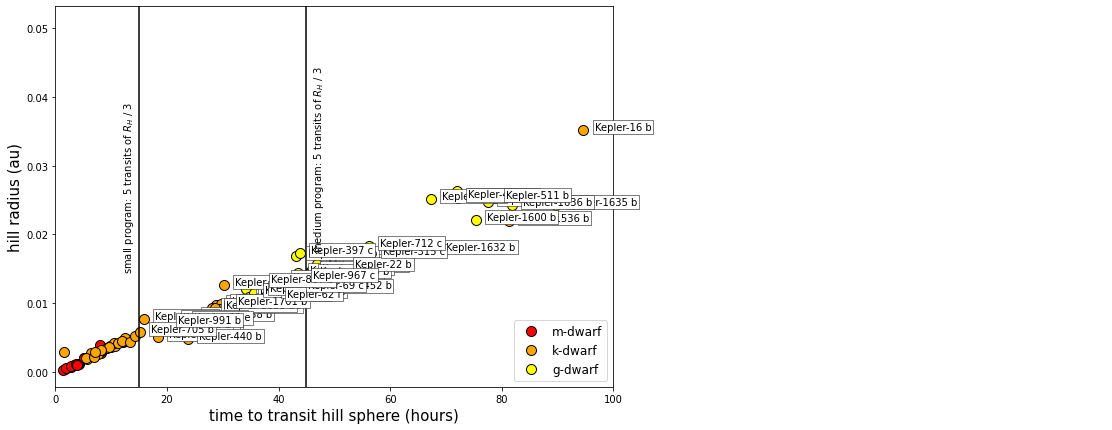

In [15]:
c = ((th / 3 * 5) < 200) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 100)
#pl.ylim(0, 0.06)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    if 2*t > 15:
        if pname == 'Kepler-442 b':
            pl.annotate(pname, xy=(2*t+2, r+0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        elif pname == 'Kepler-47 c':
            pl.annotate(pname, xy=(2*t+2, r-0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        else:
            pl.annotate(pname, xy=(2*t+2, r), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')
pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates.pdf')

/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1346: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1346: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:823: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))


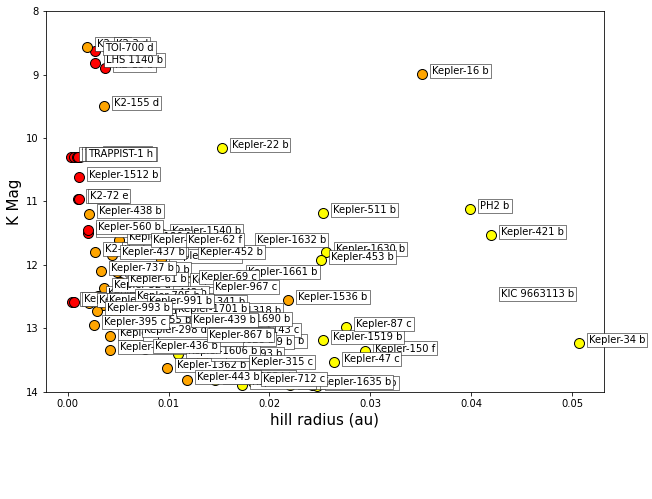

In [16]:
c = ((th / 3 * 5) < 200) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(rh[c][mdwarf], hz_planets[c]['sy_kmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(rh[c][kdwarf], hz_planets[c]['sy_kmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(rh[c][gdwarf], hz_planets[c]['sy_kmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(14, 8)

for r, kmag, hname in zip(rh[c], hz_planets[c]['sy_kmag'], hz_planets[c]['pl_name']):
        pl.annotate(hname, xy=(r+0.001, kmag), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
#pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
#            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
#pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
#            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('K Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates_kmag.pdf')

In [17]:
hz_planets['sy_kmag']

4.714
4.651
8.916
10.404
11.945
3.75
3.75
3.75
4.537
4.015
4.015


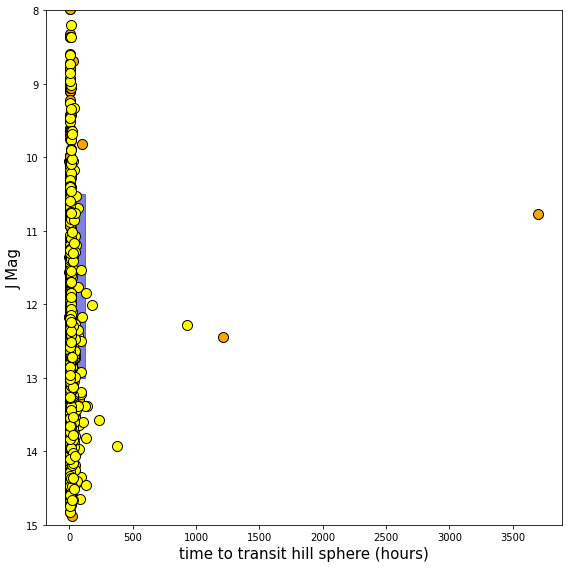

In [50]:
from matplotlib.patches import Rectangle

c = (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(8, 8))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], hz_planets[c]['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], hz_planets[c]['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], hz_planets[c]['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(15, 8)

#for t, jmag, hname in zip(2*th[c], hz_planets[c]['sy_jmag'], hz_planets[c]['pl_name']):
#        pl.annotate(hname, xy=(t+1, jmag), rotation=0, 
#                    bbox=dict(fc="white", lw=0.5, pad=2))

rect = Rectangle((0, 13), 75 * 5 / 3, -2.5, alpha=0.5, color='mediumblue')
pl.gca().add_patch(rect)
inrange = (hz_planets['tran_flag'] == 1) & (hz_planets['sy_jmag'] < 13) & (hz_planets['sy_jmag'] > 10.5) & (hz_planets['pl_rade'] > 5)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.tight_layout()
pl.savefig('/Users/tgordon/Desktop/candidates_transit_time_jmag.pdf')

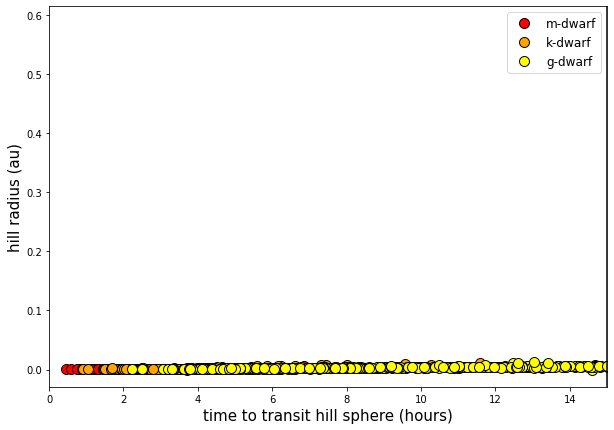

In [51]:
c = (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 15)
#pl.ylim(0.01, 0.03)

#for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
#    pl.annotate(pname, xy=(2*t+0.3, r), rotation=0, 
#                bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12)
pl.savefig('/Users/tgordon/Desktop/candidates_zoom.pdf')

In [52]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[inrange]
targets = unique(targets, keys='pl_name')
targets.sort('sy_jmag')
targets.reverse()
fmtdict = {'pl_name': '%20.20s', 'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_rade', 'pl_orbper'], comment=False, delimiter='\t', formats=fmtdict)

pl_name	sy_jmag	pl_hillrad	st_teff	pl_rade	pl_orbper
Kepler-951 b	12.920	0.010	4855.0	5.76	71.52543938
KOI-1783.01	12.917	0.018	6215.0	7.5	134.4786723
KOI-1783.02	12.917	0.028	5791.0	6.36	284.063137
Kepler-79 d	12.913	nan	6189.0	7.59	52.09059
Kepler-486 b	12.895	0.022	4939.0	11.31	30.36044667
Kepler-289 c	12.861	0.104	6279.0	18.17	125.86543389
Kepler-820 b	12.841	0.044	6505.0	9.46	127.8334997
K2-114 b	12.835	0.013	5044.0	10.67	11.391013
KIC 9663113 b	12.823	0.042	6226.0	5.8	572.376632
KOI-351 h	12.790	0.051	6238.0	10.01	331.6011081
KOI-351 g	12.790	0.023	6238.0	6.86	210.6031105
PH1 b	12.714	0.018	6407.0	6.18	138.317
Kepler-9 c	12.710	0.009	5777.0	8.22	38.907202
Kepler-9 b	12.710	0.006	5774.0	8.29	19.23891
NGTS-1 b	12.702	0.005	3916.0	14.908	2.647298
HATS-49 b	12.692	0.002	4405.0	8.575	4.1480467
KIC 5437945 b	12.667	0.038	6340.0	6.7	440.786134
Kepler-460 c	12.667	nan	6340.0	6.1	220.1303357
HATS-47 b	12.653	0.006	4512.0	12.52	3.9228038
HATS-71 b	12.605	0.007	3405.0	11.478	3.7955202
Keple

In [53]:
targets.write('targets.txt', format='ascii')

In [54]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[inrange]
targets = unique(targets, keys='pl_name')
targets.sort('sy_jmag')
fmtdict = {'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets[(targets['sy_jmag'] < 13)]['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_minmass_med', 'pl_rade', 'cb_flag', 'pl_orbper'], comment=False, delimiter='\t', formats=fmtdict)

pl_name	sy_jmag	pl_hillrad	st_teff	pl_minmass_med	pl_rade	cb_flag	pl_orbper
Kepler-396 c	10.672	0.012	5579.0	0.086	6.07	0	88.5112563
Kepler-432 b	10.684	0.036	5061.0	6.935	9.6	0	52.50128
Kepler-450 b	10.708	0.005	6215.0	0.077	5.93	0	28.45492088
TOI-216.02	10.759	0.005	5026.0	0.177	7.69	0	17.089
TOI-216.01	10.759	0.029	5026.0	7.658	11.29	0	34.556
EPIC 248847494 b	10.765	0.585	4898.0	6.212	12.442	0	3650.0
HAT-P-18 b	10.822	0.007	4803.0	5.039	11.153	0	5.508023
NGTS-11 b	10.855	0.022	5050.0	3.701	9.158	0	35.45533
TOI-1338 b	10.950	0.015	6050.0	0.116	6.85	1	95.174
Kepler-1514 b	10.953	0.272	6382.0	176.854	22.02	0	217.8317626
Kepler-462 b	10.983	0.010	7717.0	0.062	5.01	0	84.6879808
Kepler-1605 b	11.064	0.011	5447.0	0.077	5.18	0	85.7565495
HATS-17 b	11.082	0.006	5846.0	0.332	8.709	0	16.254611
K2-33 b	11.095	0.002	3410.0	0.094	5.76	0	5.42513
K2-280 b	11.141	0.006	5742.0	0.177	7.67	0	19.895202
HAT-P-54 b	11.145	0.006	4390.0	6.212	10.581	0	3.799847
Kepler-1515 b	11.163	0.032	6471.0	0.300	9.17	0	

<ipython-input-55-b09a42d0ee4c>:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  pl.tight_layout()


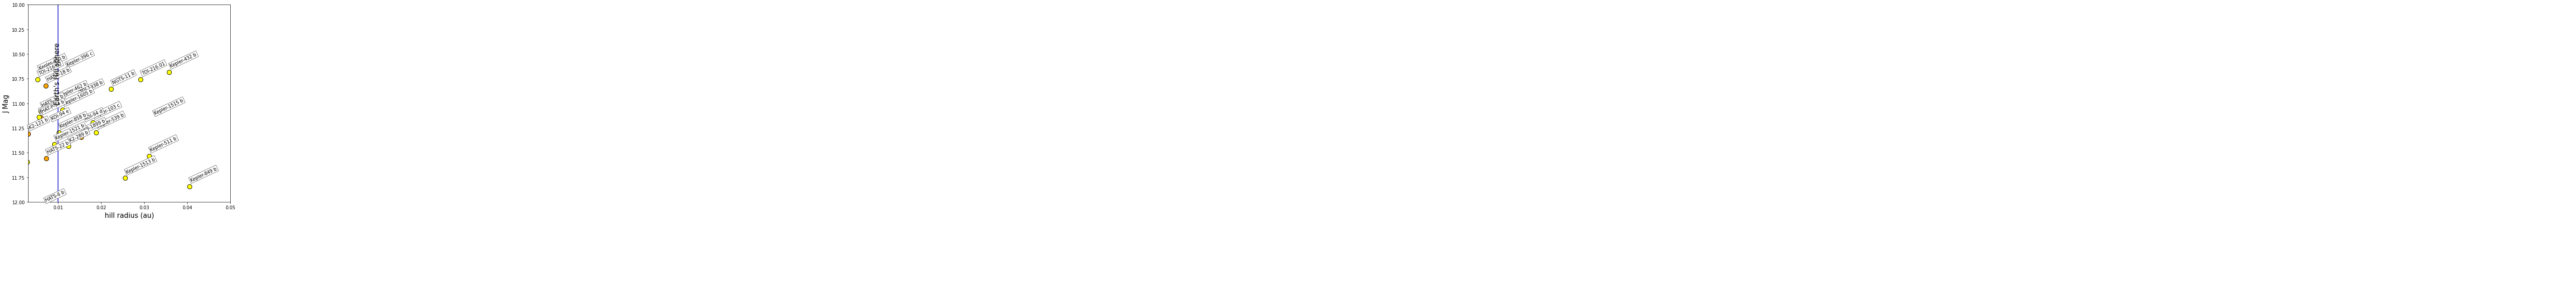

In [55]:
pl.figure(figsize=(8, 8))
plottargets = targets
mdwarf = plottargets['st_teff'] < 3500
kdwarf = (plottargets['st_teff'] >= 3500) & (plottargets['st_teff'] < 5000)
gdwarf = (plottargets['st_teff'] >= 5000) & (plottargets['st_teff'] < 6000)
pl.plot(plottargets['pl_hillrad'][mdwarf], plottargets['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(plottargets['pl_hillrad'][kdwarf], plottargets['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(plottargets['pl_hillrad'][gdwarf], plottargets['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(13.5, 7)

do_not_annotate = ['TRAPPIST-1 b', 
                   'TRAPPIST-1 c', 
                   'TRAPPIST-1 d', 
                   'TRAPPIST-1 e', 
                   'TRAPPIST-1 f', 
                   'TRAPPIST-1 g',
                   'TRAPPIST-1 h',
                   'Kepler-186 f', 
                   'Kepler-1544 b', 
                   'Kepler-967 c', 
                   'KOI-1783.02', 
                   'Kepler-155 c', 
                   'Kepler-62 f']
pl.annotate("Kepler-62 f", xy=(0.01095, 12.24), xytext=(0.00925, 11.6), arrowprops=dict(arrowstyle="->"), 
           bbox=dict(fc="white", lw=0.5, pad=2))
for r, jmag, hname in zip(plottargets['pl_hillrad'], plottargets['sy_jmag'], plottargets['pl_name']):
    if hname not in do_not_annotate:
        pl.annotate(hname, xy=(r+0.0001, jmag-0.05), rotation=25, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.annotate('TRAPPIST-1 b, c, d, e, f, g, h', xy=(0.002, 11.4), bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-186 f', xy=(0.005, 12.4),  bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-1544 f', xy=(0.0093, 12.4),  bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-967 c', xy=(0.014, 12.9), bbox=dict(fc="white", lw=0.5, pad=2))
pl.annotate('Kepler-155 c', xy=(0.004, 12.65), bbox=dict(fc="white", lw=0.5, pad=2))

pl.annotate('Earth\'s Hill sphere', xy=(0.009, 11), rotation=90, fontsize=15)
#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
pl.axvline(0.01, color='mediumblue')
#pl.axvline(0.001, color='r')

#pl.xlim(0.0, 0.005)

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
pl.ylim(12, 10)
pl.xlim(0.003, 0.05)
#pl.legend(fontsize=12, loc='lower right')
pl.tight_layout()
pl.savefig('figures/candidates_jmag.pdf')
pl.savefig('/Users/tgordon/Desktop/candidates_hill_rad_jmag.pdf')

In [56]:
targets.sort('pl_name')
targets['pl_masse'] = targets['pl_minmass_med']*317.8
ascii.write(targets['pl_name', 
                    'sy_jmag', 
                    'pl_hillrad', 
                    'st_teff', 
                    'pl_rade', 
                    'pl_masse',
                    'ra',
                    'dec'], format='latex', 
            formats={'Hill radius (au)': '%0.3f', 'Mass, M$_\\bigoplus$': '%0.2f'}, 
            names=['planet name', 
                   'J mag', 
                   'Hill radius (au)', 
                   r'T$_\mathrm{eff}$ (K)', 
                   'Radius R$_\\bigoplus$', 'Mass, M$_\\bigoplus$', 'RA', 'Dec'])

\begin{table}
\begin{tabular}{cccccccc}
planet name & J mag & Hill radius (au) & T$_\mathrm{eff}$ (K) & Radius R$_\bigoplus$ & Mass, M$_\bigoplus$ & RA & Dec \\
CoRoT-10 b & 12.527 & 0.013 & 5075.0 & 10.87 & 1787.76 & 291.0636813 & 0.7460143 \\
CoRoT-8 b & 12.154 & 0.002 & 5080.0 & 6.389 & 37.01 & 291.5885696 & 1.4262972 \\
CoRoT-9 b & 12.175 & 0.051 & 5625.0 & 11.949 & 1974.18 & 280.7866461 & 6.2040783 \\
EPIC 248847494 b & 10.765 & 0.585 & 4898.0 & 12.442 & 1974.18 & 159.3890808 & 11.8427484 \\
HAT-P-18 b & 10.822 & 0.007 & 4803.0 & 11.153 & 1601.35 & 256.346376 & 33.0123251 \\
HAT-P-54 b & 11.145 & 0.006 & 4390.0 & 10.581 & 1974.18 & 99.8979924 & 25.4824005 \\
HATS-17 b & 11.082 & 0.006 & 5846.0 & 8.709 & 105.39 & 192.1895676 & -47.6136789 \\
HATS-22 b & 11.556 & 0.007 & 4803.0 & 10.682 & 2203.99 & 174.0098693 & -29.5433642 \\
HATS-47 b & 12.653 & 0.006 & 4512.0 & 12.52 & 1601.35 & 287.4844021 & -49.6649424 \\
HATS-49 b & 12.692 & 0.002 & 4405.0 & 8.575 & 85.49 & 6.6135927 & -56.344

In [57]:
transit_time = np.array([targets['pl_tranmid'] + i*targets['pl_orbper'] for i in range(100)]).T

In [58]:
from astropy.time import Time

def tobjd(time):
    return Time(time, format='isot', scale='utc').jd

import matplotlib.dates as dates
date_x = [dates.datestr2num(t[:10]) for t in Time(vis[:, 0], format='jd').iso]
plot_date = lambda jd: dates.datestr2num([(Time(jd, format='jd').iso)[:10] for jd in jd])

vis = np.loadtxt('../visibility/jwst_gtvt/Kepler-22.dat', skiprows=19, converters={0: tobjd})

NameError: name 'vis' is not defined

In [ ]:
windows = np.loadtxt(open('../visibility/jwst_gtvt/Kepler-22.dat').readlines()[9:13], converters={0: tobjd, 1: tobjd})
breaks = [np.where(np.isclose(vis[:, 0], windows[:,1][i], rtol=1e-12))[0][0] for i in range(len(windows))]
breaks = np.insert(breaks, 0, 0)

In [ ]:
i = np.where(targets['pl_name'] == 'Kepler-22 b')[0][0]

print("max uncertainty: {0} hours".format(100*2*24*targets['pl_orbpererr1'][i]))

for j in range(len(early)):
    pl.axvline(transit_time[i][j], color='k')
[pl.fill_between(vis[:, 0][breaks[i]+1:breaks[i+1]], vis[:, 1][breaks[i]+1:breaks[i+1]], vis[:, 2][breaks[i]+1:breaks[i+1]], color='red') for i in range(len(breaks)-1)]
pl.xlim(vis[0, 0], vis[-1, 0])
x_ticks_labels = [t[:10] for t in Time(pl.xticks()[0], format='jd').iso]
pl.gca().set_xticklabels(x_ticks_labels, rotation=45, fontsize=10, ha='right');

In [ ]:
import matplotlib.dates as dates
date_x = [dates.datestr2num(t[:10]) for t in Time(vis[:, 0], format='jd').iso]
plot_date = lambda jd: dates.datestr2num([(Time(jd, format='jd').iso)[:10] for jd in jd])

In [ ]:
pl.plot_date(plot_date(vis[:, 0]), np.ones_like(vis[:, 0]))
pl.gcf().autofmt_xdate()

In [ ]:
pl.axvspan(early[i][j], late[i][j])

In [ ]:
targets['pl_orbpererr1']

In [ ]:
mr.Rstat2M(mean=9.21 / 11.2089, std=0.5 / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)

In [ ]:
for t in targets:
    print(t['pl_name'], " ", t['st_teff'], " ", 1.02*t['st_teff'])

In [ ]:
targets[targets['pl_name'] == 'Kepler-62 e']['pl_hilltime']

In [ ]:
from astropy.time import Time
Time(2454983.404, format='jd').iso

In [ ]:
targets[targets['pl_name'] == 'Kepler-511 b']['pl_hilltime']

In [59]:
p = targets[targets['pl_name'] == 'Kepler-62 e']

In [60]:
me_ms = 0.000003003
24 * t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])

<MaskedColumn name='pl_orbsmax' dtype='float64' length=0>

In [61]:
hill(0.8217 * me_ms, p['st_mass'], p['pl_orbsmax'], p['pl_orbeccen'])

<MaskedColumn name='pl_orbsmax' dtype='float64' length=0>

In [62]:
p['pl_orbsmax'] * (1 - p['pl_orbeccen']) * ((0.8217 * mj_ms)/(3*p['st_mass'])) ** (1./3.)

<MaskedColumn name='pl_orbsmax' dtype='float64' length=0>

In [63]:
p['pl_minmass_med'] * mj_ms / me_ms

<MaskedColumn name='pl_minmass_med' dtype='float64' length=0>

In [64]:
planets[planets['pl_name'] == 'Kepler-1513 b']['sy_jmag']

11.758
11.758
11.758
11.758
11.758
11.758
11.758
11.758


In [65]:
Time([2455110.504085 + 160.88465087*i for i in range(100)], format='jd').iso

array(['2009-10-06 00:05:52.944', '2010-03-15 21:19:46.779',
       '2010-08-23 18:33:40.614', '2011-01-31 15:47:34.450',
       '2011-07-11 13:01:28.285', '2011-12-19 10:15:22.120',
       '2012-05-28 07:29:15.955', '2012-11-05 04:43:09.790',
       '2013-04-15 01:57:03.625', '2013-09-22 23:10:57.461',
       '2014-03-02 20:24:51.296', '2014-08-10 17:38:45.131',
       '2015-01-18 14:52:38.966', '2015-06-28 12:06:32.801',
       '2015-12-06 09:20:26.636', '2016-05-15 06:34:20.472',
       '2016-10-23 03:48:14.307', '2017-04-02 01:02:08.142',
       '2017-09-09 22:16:01.977', '2018-02-17 19:29:55.812',
       '2018-07-28 16:43:49.647', '2019-01-05 13:57:43.483',
       '2019-06-15 11:11:37.318', '2019-11-23 08:25:31.153',
       '2020-05-02 05:39:24.988', '2020-10-10 02:53:18.823',
       '2021-03-20 00:07:12.658', '2021-08-27 21:21:06.494',
       '2022-02-04 18:35:00.329', '2022-07-15 15:48:54.164',
       '2022-12-23 13:02:47.999', '2023-06-02 10:16:41.834',
       '2023-11-10 07:30

In [66]:
targets[targets['pl_name'] == 'Kepler-1511654 b']['pl_radeerr1']

<MaskedColumn name='pl_radeerr1' dtype='float64' length=0>

In [67]:
mr.Rstat2M(mean=9.16 / 11, std=3.91 / 11, unit='Earth', sample_size=100, grid_size=100)

Radius range out of model expectation. Returning None.


In [68]:
160.19035492829846 / 311

0.5150815271006381

In [69]:
t0 = targets[targets['pl_name'] == 'Kepler-1514 b']['pl_tranmid']
per = targets[targets['pl_name'] == 'Kepler-1514 b']['pl_orbper']
planets[planets['pl_name'] == 'Kepler-1514 b']['pl_rade']

11.82
12.185
11.17
22.02
22.02
--
--
22.02


In [70]:
Time([t0 + i*per for i in range(20, 30)], format='jd').iso

array([['2021-08-01 22:55:50.016'],
       ['2022-03-07 18:53:34.305'],
       ['2022-10-11 14:51:18.593'],
       ['2023-05-17 10:49:02.882'],
       ['2023-12-21 06:46:47.171'],
       ['2024-07-26 02:44:31.459'],
       ['2025-02-28 22:42:15.748'],
       ['2025-10-04 18:40:00.036'],
       ['2026-05-10 14:37:44.325'],
       ['2026-12-14 10:35:28.614']], dtype='<U23')

In [71]:
targets[targets['pl_name'] == 'Kepler-1513 b']['pl_hilltime'] / 4# + 5.3

8.604945809455554


In [97]:
targets[targets['pl_name'] == 'Kepler-62 e']['pl_trandur']

<MaskedColumn name='pl_trandur' dtype='float64' length=0>

In [107]:
dur * 3 / 2

16.1304


In [108]:
dur = hz_planets[hz_planets['pl_name'] == 'Kepler-1513 b']['pl_trandur']
per = hz_planets[hz_planets['pl_name'] == 'Kepler-1513 b']['pl_orbper'] * 24
print(1 - (dur * 3 / 2 + 0.5) / per, 1 - (dur * 3 / 2 -0.5) / per)

    pl_trandur    
------------------
0.9956929804702548     pl_trandur    
------------------
0.9959519651927957


In [102]:
hz_planets[hz_planets['pl_name'] == 'Kepler-62 e']['sy_vmag']

13.965


In [93]:
141498 / (60*60)

39.305

In [94]:
94318 / (60*60)

26.199444444444445

In [95]:
115865.88 / (60*60)

32.18496666666667

In [127]:
targets[targets['pl_name'] == 'Kepler-1513 b']['pl_hilltime'] / 2 - (dur / 2)

11.833091618911109


In [134]:
targets[targets['pl_name'] == 'Kepler-1513 b']['sy_kmag']

11.309


In [141]:
pl = targets[targets['pl_name'] == 'Kepler-1513 b']

In [149]:
pl['st_rad']

1.04


In [144]:
mr.Rstat2M(mean=pl['pl_rade'] / 11.2089, std=pl['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)

(0.45642409217174784, 32.68903254740294, 0.39427220648961875)

In [172]:
mj_ms = 0.0009543
au_rs = 1/215.032
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P, rs: (hill(mp, ms, a, e) + rs * au_rs) * P / (2 * np.pi * a)
a_au = (7.496e-6 * (pl['pl_orbper']**2)) ** (1/3)
thill = (hill(1.43*mj_ms, 0.99, a_au, 0.0) + 1 * au_rs) * pl['pl_orbper'] / (2*np.pi * a_au) * 24

In [181]:
thill*0.4 + 10.621

31.56387830364187


In [164]:
114810.408/ (60 * 60)

31.891779999999997

In [165]:
57932.94 / (60*60)

16.092483333333334

In [166]:
pl['pl_trandur']

10.7536


In [184]:
duration_hours = 114810.408 / (60*60)

In [188]:
1 - (duration_hours/2 + 0.5) / (pl['pl_orbper'] * 24)

0.9957407657414108


In [189]:
1 - (duration_hours/2 - 0.5) / (pl['pl_orbper'] * 24)

0.9959997504639517


In [191]:
pl['pl_tranmid'] 

2455110.504085
